## Test the Laplace approximation on a simulated SLDS model

#### Imports

In [3]:
from jax import vmap
import jax.numpy as jnp
import jax.random as jr
import copy
import matplotlib.pyplot as plt
from dynamax.slds.models import SLDS
from dynamax.slds.test_models import simulate_slds
from dynamax.slds.laplace import laplace_approximation, block_tridiag_mvn_sample
from tensorflow_probability.substrates import jax as tfp
from dynamax.utils.plotting import plot_states_and_timeseries
tfd = tfp.distributions
tfb = tfp.bijectors
MVN = tfd.MultivariateNormalFullCovariance

#### Simulate data

#### Switching linear dynamical systems (SLDS) in JAX

An SLDS is a state space model with discrete latent states $z_t \in [K]$, continuous states $x_t \in \mathbb{R}^D$, and observations $y_t \in \mathbb{R}^N$. The model is,

\begin{align}
p(z_{1:T}, x_{1:T}, y_{1:T}; \theta)
&= \prod_{t=1}^T \mathrm{Cat}(z_t \mid \pi_{z_{t-1}}) \, \mathrm{N}(x_t \mid A_{z_t} x_{t-1} + b_{z_t}, Q_{z_t}) \, \mathrm{N}(y_t \mid C x_t + d, R)
\end{align}

with parameters $\theta = \{\{\pi_k, A_k, b_k, Q_k\}_{k=1}^K, C, d, R\}$. (We're ignoring the intial distribution, but that also has some parameters.)

_Note: we're assuming the emission parameters are shared by all discrete states, but we could relax that._


First, let's try to sample from this model.

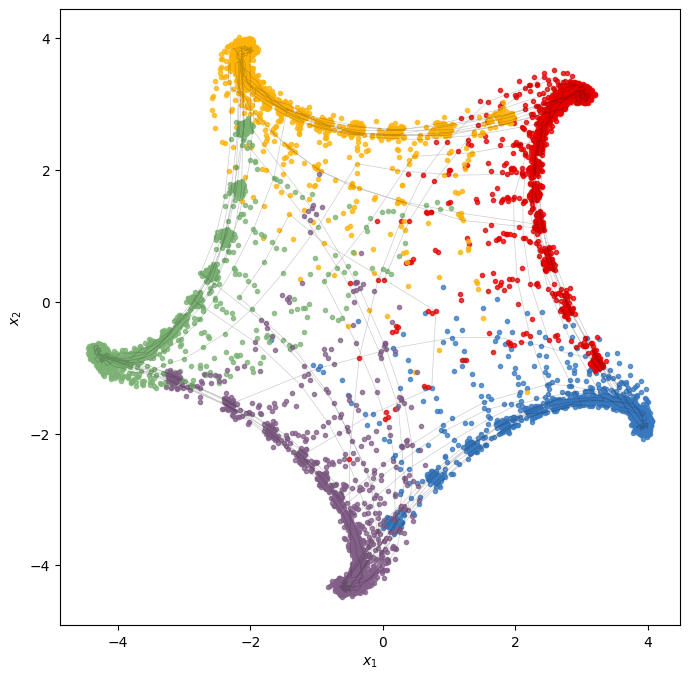

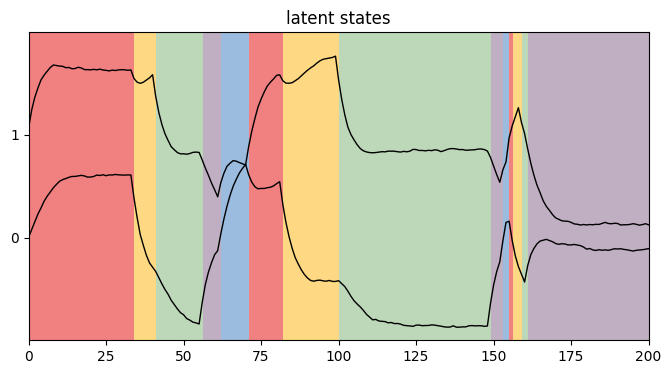

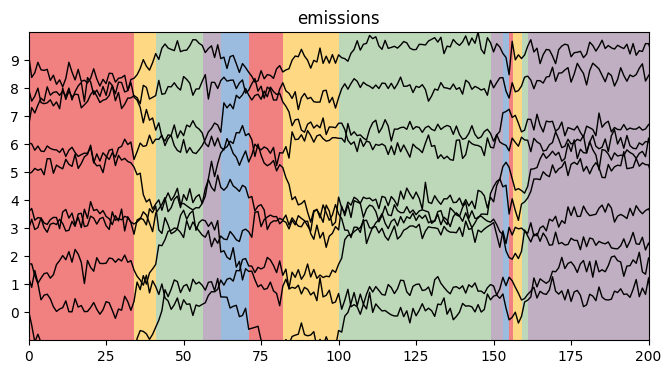

In [4]:
# initialize random number generator
key = jr.PRNGKey(0)

# simulate data from a toy SLDS model
zs, xs, ys, slds, params = simulate_slds(key)

# create distributions that are passed to the laplace approximation
P = params.transition_matrix
As = params.dynamics_matrices
bs = params.dynamics_biases
Qs = params.dynamics_covs
C = params.emission_matrix
d = params.emission_bias
R = params.emission_cov

latent_dim = slds.latent_dim
emission_dim = slds.emission_dim
num_states = slds.num_states

#### Run the laplace approximation

In [5]:
# define log prob functions that close over zs and params
log_prob = lambda xs, ys: slds.log_prob(ys, zs, xs, params)
initial_distribution = lambda x0: MVN(jnp.zeros(latent_dim), jnp.eye(latent_dim)).log_prob(x0)
dynamics_distribution = lambda t, xt, xtp1: MVN(As[zs[t+1]] @ xt + bs[zs[t+1]], Qs[zs[t+1]]).log_prob(xtp1)
emission_distribution = lambda t, xt, yt: MVN(C @ xt + d, R).log_prob(yt)

# run the laplace approximation
log_normalizer, Ex, ExxT, ExxnT, J_diag, J_lower_diag, h = \
laplace_approximation(log_prob, 
                    initial_distribution,
                    dynamics_distribution, 
                    emission_distribution, 
                    jnp.zeros_like(xs), 
                    ys, 
                    method="L-BFGS", 
                    num_iters=50)

In [6]:
# sample from the approximate posterior
x_sample = block_tridiag_mvn_sample(jr.PRNGKey(0), J_diag, J_lower_diag, h)

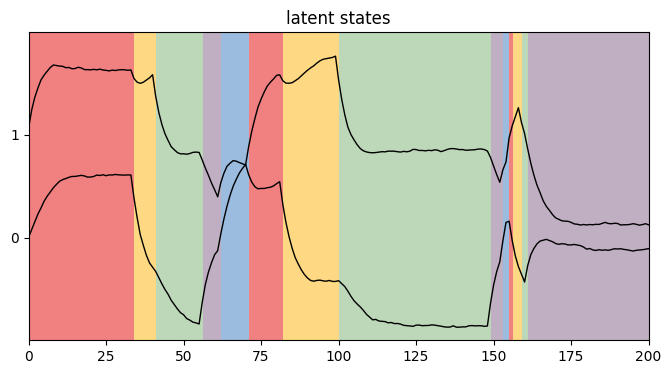

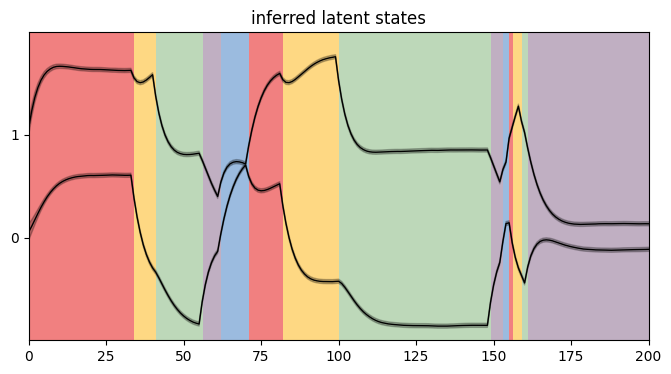

In [8]:
# visualize the results
fig, ax = plot_states_and_timeseries(zs, xs)
ax.set_xlim(0, 200)
ax.set_title("latent states")
plt.show()

cov_x = ExxT - jnp.einsum('ti,tj->tij', Ex, Ex)
fig, ax = plot_states_and_timeseries(zs, Ex, jnp.sqrt(vmap(jnp.diag)(cov_x)))
ax.set_xlim(0, 200)
ax.set_title("inferred latent states")
plt.show()

#### Now fit with Laplace EM

In [15]:
initialize_params = copy.deepcopy(params)
test_slds = SLDS(num_states, latent_dim, emission_dim)
lps, fit_zs, fit_xs, fit_params, final_key = test_slds._fit_laplace_em(jr.PRNGKey(0),
                                                            ys, zs, xs, 
                                                            initialize_params, 
                                                            num_iters=50)

Text(0, 0.5, 'log prob')

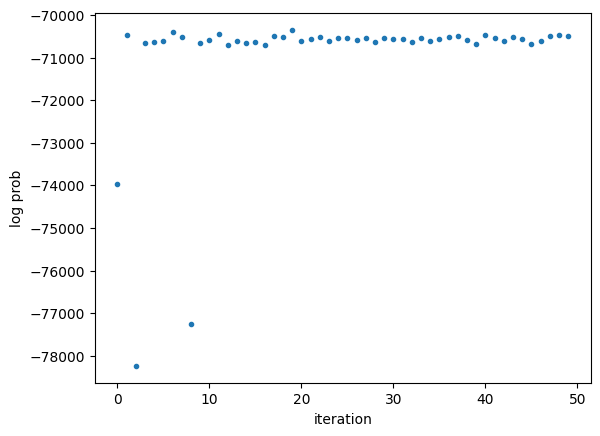

In [17]:
# Visualize log probs
plt.plot(lps, '.')
plt.xlabel("iteration")
plt.ylabel("log prob")

Text(0.5, 1.0, 'true latent states')

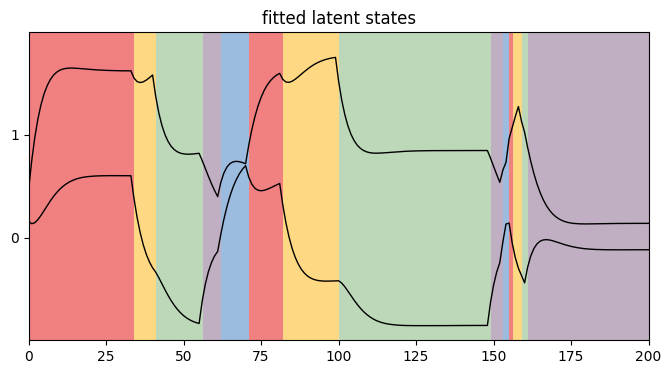

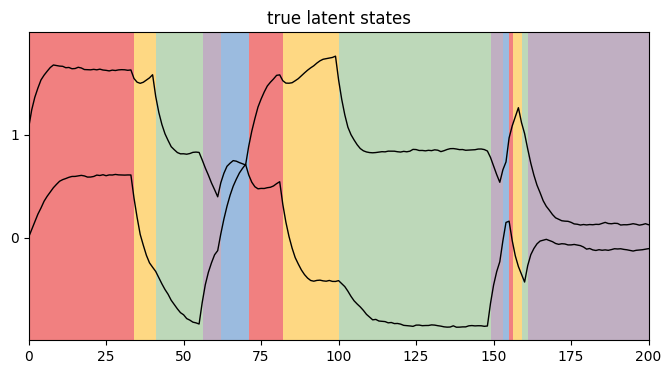

In [18]:
# Visualize inferred states
fig, ax = plot_states_and_timeseries(fit_zs, fit_xs)
ax.set_xlim(0, 200)
ax.set_title("fitted latent states")

fig, ax = plot_states_and_timeseries(zs, xs)
ax.set_xlim(0, 200)
ax.set_title("true latent states")